#### Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

#### Encoder

In [5]:
# class Encoder(nn.Module):
#     def __init__(self, input_dim=2, embed_dim=128):
#         super(Encoder, self).__init__()
#         self.embed = nn.Linear(input_dim, embed_dim)

#     def forward(self, x):
#         return self.embed(x)  # [B, N, D]

class Encoder(nn.Module):
    def __init__(self, input_dim=2, embed_dim=128, seq_len=20):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(seq_len, embed_dim)
        self.fc = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        batch_size, seq_len, _ = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        pos_emb = self.embedding(positions)  # (batch, seq_len, embed_dim)
        x_proj = self.fc(x)                  # (batch, seq_len, embed_dim)
        return x_proj + pos_emb


#### Attention Mechanism

In [6]:
class Attention(nn.Module):
    def __init__(self, embed_dim=128):
        super(Attention, self).__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Parameter(torch.rand(embed_dim))

    def forward(self, decoder_hidden, encoder_outputs, mask):
        q = self.query(decoder_hidden).unsqueeze(1)  # [B, 1, D]
        k = self.key(encoder_outputs)  # [B, N, D]
        scores = torch.matmul(q, k.transpose(-2,-1)).squeeze(1)  # [B, N]

        # Safety check
        mask = mask.bool()  # Ensure it's boolean
        scores = scores.masked_fill(mask, float('-inf'))

        probs = torch.softmax(scores, dim=-1)
        return probs



#### Actor Network

In [7]:
class Actor(nn.Module):
    def __init__(self, embed_dim=128):
        super(Actor, self).__init__()
        self.encoder = Encoder(2, embed_dim)
        self.decoder = nn.GRUCell(embed_dim, embed_dim)
        self.attention = Attention(embed_dim)
        self.embed_dim = embed_dim
        self.init_input = nn.Parameter(torch.rand(embed_dim))

    def forward(self, coords):
        B, N, _ = coords.size()
        device = coords.device
        embedded = self.encoder(coords)

        mask = torch.zeros(B, N, dtype=torch.bool, device=device)
        hidden = torch.zeros(B, self.embed_dim, device=device)
        inputs = self.init_input.unsqueeze(0).repeat(B, 1)

        sequences = []
        log_probs = []
        for _ in range(N):
            hidden = self.decoder(inputs, hidden)
            probs = self.attention(hidden, embedded, mask)
            dist = torch.distributions.Categorical(probs)
            selected = dist.sample()
            sequences.append(selected)
            log_probs.append(dist.log_prob(selected))
            mask = mask.clone()
            mask.scatter_(1, selected.unsqueeze(1), True)
            inputs = embedded[torch.arange(B), selected]

        return torch.stack(sequences, dim=1), torch.stack(log_probs, dim=1)


#### Critic Network

In [8]:
class Critic(nn.Module):
    def __init__(self, embed_dim=128):
        super(Critic, self).__init__()
        self.encoder = Encoder(2, embed_dim)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, coords):
        embedded = self.encoder(coords).mean(dim=1)  # [B, D]
        return self.fc(embedded).squeeze(-1)  # [B]

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#seed
torch.manual_seed(42)
np.random.seed(42)

#### Computing Path Length

In [ ]:
def compute_tour_length(coords, sequence):
    B, N, _ = coords.size()
    idx = sequence.unsqueeze(-1).expand(-1, -1, 2)  # [B, N, 2]
    ordered = coords.gather(1, idx)
    shifted = torch.roll(ordered, shifts=-1, dims=1)
    return torch.norm(ordered - shifted, dim=2).sum(dim=1)  # [B]
#example usage
coords = torch.tensor([[[0.0, 0.0], [1.0, 2.0], [2.0, 1.0], [3.0, 3.0], [4.0, 2.0], [5.0, 5.0], [6.0, 4.0]]])
sequence = torch.tensor([[0, 1, 3, 5, 6, 4, 2]])
length = compute_tour_length(coords, sequence)
print(f"Tour length: {length.item()}")

#### Generate Problem Instances

In [ ]:
def generate_tsp_batch(batch_size, n_nodes):
    return torch.rand(batch_size, n_nodes, 2, device=device)

#### Training Loop Actual

In [ ]:
def train_tsp_actor_critic_mulb(n_instances=100000,n_epochs=20, batch_size=256, n_nodes=20, lr=5e-4):
    # Generate and train on 100,000 problem instances (20 nodes each) in batches of 256 for 20 epochs
    total_instances = n_instances
    # batch_size = 256
    # n_nodes = 20
    # n_epochs = 20

    n_batches = total_instances // batch_size
    print(f"Total instances: {total_instances}, Batch size: {batch_size}, Nodes per instance: {n_nodes}, Epochs: {n_epochs}, Batches: {n_batches}")

    actor = Actor().to(device)
    critic = Critic().to(device)
    optimizer_actor = optim.Adam(actor.parameters(), lr)
    optimizer_critic = optim.Adam(critic.parameters(), lr)

    for b in tqdm(range(n_batches)):
        batch = generate_tsp_batch(batch_size, n_nodes)

        for epoch in range(n_epochs):
            actor.train()
            critic.train()

            sequence, log_probs = actor(batch)
            reward = compute_tour_length(batch, sequence).detach()

            # Critic prediction
            baseline = critic(batch)

            # Losses
            advantage = (reward - baseline.detach())
            actor_loss = -(advantage * log_probs.sum(dim=1)).mean()

            critic_loss = nn.MSELoss()(baseline, reward)

            # Update
            optimizer_actor.zero_grad()
            actor_loss.backward()
            optimizer_actor.step()

            optimizer_critic.zero_grad()
            critic_loss.backward()
            optimizer_critic.step()

        # print(f"Epoch {b+1}/{n_batches} | Reward: {reward.mean():.4f} | Actor Loss: {actor_loss.item():.4f} | Critic Loss: {critic_loss.item():.4f}")
        
    torch.save(actor.state_dict(), "actor_tspK.pth")
    torch.save(critic.state_dict(), "critic_tspK.pth")


In [ ]:
if __name__ == "__main__":
    train_tsp_actor_critic_mulb(n_instances=20000, n_epochs=20, batch_size=256, n_nodes=20, lr=5e-4)

#### Training Loop

In [ ]:
# def train_tsp_actor_critic(n_epochs=20, batch_size=256, n_nodes=20, lr=5e-4):
#     actor = Actor().to(device)
#     critic = Critic().to(device)

#     torch.autograd.set_detect_anomaly(True)
#     optimizer_actor = optim.Adam(actor.parameters(), lr=lr)
#     optimizer_critic = optim.Adam(critic.parameters(), lr=lr)
    
#     for epoch in tqdm(range(n_epochs)):
#         actor.train()
#         critic.train()

#         batch = generate_tsp_batch(batch_size, n_nodes)
#         sequence, log_probs = actor(batch)
#         reward = compute_tour_length(batch, sequence).detach()

#         # Critic prediction
#         baseline = critic(batch)

#         # Losses
#         advantage = (reward - baseline.detach())
#         actor_loss = -(advantage * log_probs.sum(dim=1)).mean()

#         critic_loss = nn.MSELoss()(baseline, reward)

#         # Update
#         optimizer_actor.zero_grad()
#         actor_loss.backward()
#         optimizer_actor.step()

#         optimizer_critic.zero_grad()
#         critic_loss.backward()
#         optimizer_critic.step()

#     print(f"Epoch {epoch+1}/{n_epochs} | Reward: {reward.mean():.4f} | Actor Loss: {actor_loss.item():.4f} | Critic Loss: {critic_loss.item():.4f}")
    
#     torch.save(actor.state_dict(), "actor_tsp.pth")
#     torch.save(critic.state_dict(), "critic_tsp.pth")
# if __name__ == "__main__":
#     train_tsp_actor_critic(n_epochs=20, batch_size=256, n_nodes=20, lr=5e-4)
    

### TEST

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
@torch.no_grad()
def greedy_decode(actor, coords):
    actor.eval()
    B, N, _ = coords.size()
    embedded = actor.encoder(coords)
    mask = torch.zeros(B, N, dtype=torch.bool, device=device)
    hidden = torch.zeros(B, actor.embed_dim, device=device)
    inputs = actor.init_input.unsqueeze(0).repeat(B, 1)

    sequences = []

    for _ in range(N):
        hidden = actor.decoder(inputs, hidden)
        q = actor.attention.query(hidden).unsqueeze(1)  # [B, 1, D]
        k = actor.attention.key(embedded)  # [B, N, D]
        scores = torch.matmul(q, k.transpose(1, 2)).squeeze(1)  # [B, N]
        scores = scores.masked_fill(mask, float('-inf'))
        selected = torch.argmax(scores, dim=1)
        sequences.append(selected)
        mask = mask.clone()
        mask.scatter_(1, selected.unsqueeze(1), True)
        inputs = embedded[torch.arange(B), selected]

    return torch.stack(sequences, dim=1)  # [B, N]


In [12]:
def plot_tour(coords_np, tour):
    coords = np.array(coords_np)
    ordered = coords[tour + [tour[0]]]
    plt.figure(figsize=(5, 5))
    plt.plot(ordered[:, 0], ordered[:, 1], 'o-')
    for i, (x, y) in enumerate(ordered[:-1]):
        plt.text(x, y, str(i), fontsize=12)
    plt.grid(True)
    plt.title("Predicted Tour")
    plt.show()


In [13]:
def evaluate_single_instance(coords_np, model_path, known_opt=None):
    actor = Actor().to(device)
    actor.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    actor.eval()

    coords = torch.tensor(coords_np, dtype=torch.float32, device=device).unsqueeze(0)  # [1, N, 2]
    tour = greedy_decode(actor, coords)[0]  # [N]

    tour_coords = coords[0][tour]
    tour_coords = torch.cat([tour_coords, tour_coords[0:1]], dim=0)  # Close loop
    cost = torch.norm(tour_coords[1:] - tour_coords[:-1], dim=1).sum().item()

    print(f"Predicted Tour: {tour.tolist()}")
    print(f"Predicted Cost: {cost:.4f}")
    if known_opt:
        print(f"Known Optimal: {known_opt:.4f} | Error: {(cost - known_opt)/known_opt * 100:.2f}%")

    plot_tour(coords_np, tour.tolist())


Predicted Tour: [6, 18, 8, 0, 7, 12, 16, 15, 1, 11, 14, 4, 10, 17, 13, 5, 19, 3, 2, 9]
Predicted Cost: 12.9367


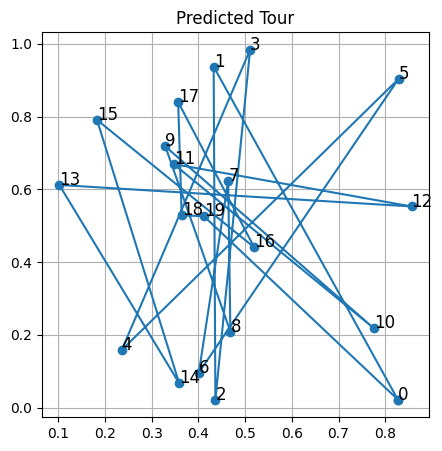

In [21]:
if __name__ == "__main__":
    coords = [[0.5106, 0.9836],
         [0.4684, 0.2091],
         [0.3641, 0.5286],
         [0.3566, 0.8401],
         [0.3469, 0.6695],
         [0.1828, 0.7909],
         [0.8269, 0.0221],
         [0.2358, 0.1584],
         [0.4363, 0.0215],
         [0.4117, 0.5261],
         [0.8564, 0.5529],
         [0.3291, 0.7180],
         [0.8285, 0.9035],
         [0.3588, 0.0668],
         [0.7760, 0.2176],
         [0.4637, 0.6236],
         [0.4009, 0.0963],
         [0.1022, 0.6120],
         [0.4326, 0.9373],
         [0.5195, 0.4404]]
    known_optimal = 2.82  # Replace with actual if known
    evaluate_single_instance(coords, "actor_tspK.pth", known_opt=None)
    


In [25]:
import itertools
import numpy as np

def total_distance(coords, tour):
    dist = 0.0
    for i in range(len(tour)):
        a = coords[tour[i]]
        b = coords[tour[(i + 1) % len(tour)]]  # wrap around to starting city
        dist += np.linalg.norm(np.array(a) - np.array(b))
    return dist

def brute_force_tsp(coords):
    n = len(coords)
    best_tour = None
    min_cost = float('inf')

    for perm in itertools.permutations(range(n)):
        cost = total_distance(coords, perm)
        if cost < min_cost:
            min_cost = cost
            best_tour = perm

    return list(best_tour), min_cost


Optimal Tour: [0, 3, 2, 5, 1, 4]
Minimal Cost: 1.9140


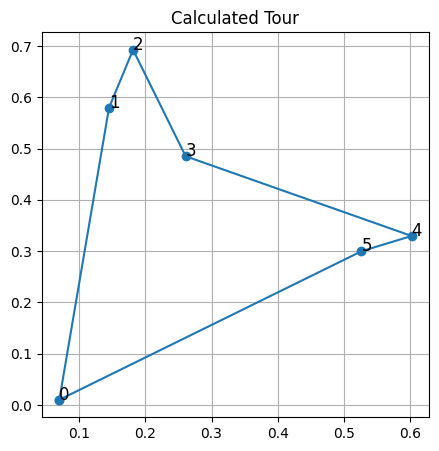

In [28]:
if __name__ == "__main__":
    
    best_tour, min_cost = brute_force_tsp(coords)
    print(f"Optimal Tour: {best_tour}")
    print(f"Minimal Cost: {min_cost:.4f}")
    #plot optimal tour
    plot_tour(coords, best_tour)


In [27]:
def plot_tour(coords_np, tour):
    coords = np.array(coords_np)
    ordered = coords[tour + [tour[0]]]
    plt.figure(figsize=(5, 5))
    plt.plot(ordered[:, 0], ordered[:, 1], 'o-')
    for i, (x, y) in enumerate(ordered[:-1]):
        plt.text(x, y, str(i), fontsize=12)
    plt.grid(True)
    plt.title("Calculated Tour")
    plt.show()